# Taller 1:
## Integrantes:
 - Giovanni Sierra Reina
 - Juan Carlos Quintero Rubiano

### Función a modelar
 $$
\frac{d^2 x}{dt^2} = F_{\text{ext}}(x, t) - kx^{p-1}
$$

In [2]:
#requirements
%pip install numpy matplotlib ipywidgets pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
import pandas as pd
import time

## Runge-Kutta 2 orden

In [4]:
#Runge-Kutta 2nd order
def rk2_step(f #funcion
                ,y #valor de la funcion en t
                ,t: float #tiempo
                ,h: float #amplitud del paso
                ):
    k1 = h*f(t, y) #evaluar la funcion en y y t
    k2 = h*f(t+h, y+k1) #evaluar la funcion en y+h*k1 y t+h

    y_next = y + 0.5*(k1+k2) #aproximacion de la funcion en t+h

    return y_next #Imagen de la funcion

In [5]:
#Ciclo Runge-Kutta 2nd order
def ciclo_rk2(f, t, y, t_values, y0_values, y1_values, tf):
    global h
    import time  # Import time module
    
    start_time = time.time()  # Start measuring time
    
    while t < tf: #mientras el tiempo sea menor al tiempo final
        if t + h > tf: #si el tiempo mas el paso es mayor al tiempo final
            h = tf - t
        y = rk2_step(f, y, t, h)
        t += h
        t_values.append(t)
        y0_values.append(y[0])
        y1_values.append(y[1])
    
    execution_time = time.time() - start_time  # Calculate execution time
    print(f"Execution time (rk2): {execution_time:.6f} seconds")
    
    return t_values, y0_values, y1_values

## Runge-Kutta 4 orden

In [6]:
#Runge-Kutta 4th order
def rk4_step(f, y, t, h):
    k1 = h*f(t, y)
    k2 = h*f(t + 0.5*h, y + 0.5*k1)
    k3 = h*f(t + 0.5*h, y + 0.5*k2)
    k4 = h*f(t + h, y + k3)

    y_next = y + (k1 + 2*k2 + 2*k3 + k4)/6

    return y_next

In [7]:
#Ciclo Runge-Kutta 4th order
def ciclo_rk4(f, t, y, t_values, y0_values, y1_values, tf):
    global h
    start_time = time.time()  # Start measuring time
    
    while t < tf: #mientras el tiempo sea menor al tiempo final
        if t + h > tf: #si el tiempo mas el paso es mayor al tiempo final
            h = tf - t
        y = rk4_step(f, y, t, h)
        t += h
        t_values.append(t)
        y0_values.append(y[0])
        y1_values.append(y[1])
    
    execution_time = time.time() - start_time  # Calculate execution time
    print(f"Execution time (rk4): {execution_time:.6f} seconds")
    return t_values, y0_values, y1_values

## Runge-Kutta 45

In [8]:
#RKF 45
def rk45_step(f, y:np.array, t: float, h: float):
    # Calculate Runge-Kutta coefficients
    k1 = h * f(t, y)
    k2 = h * f(t + h/4, y + k1/4)
    k3 = h * f(t + 3*h/8, y + 3*k1/32 + 9*k2/32)
    k4 = h * f(t + 12*h/13, y + (1932*k1 - 7200*k2 + 7296*k3)/2197)
    k5 = h * f(t + h, y + (439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104))
    k6 = h * f(t + h/2, y + (-8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40))

    # Calculate error
    err = np.abs(k1/360 - 128*k3/4275 - 2197*k4/75240 + k5/50 + 2*k6/55)

    # Calculate next y if step is accepted
    y_next = y + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5

    return y_next, err

In [9]:
#Ciclo RKF 45
def ciclo_rk45(f, t, y, t_values, y0_values, y1_values, tf, Tol = 1e-8):
    global h
    hmin = h / 64
    hmax = h * 64

    flops = 0
    sum_error = 0.0
    Eexact = 1
    Err = np.array([])
    tiempos = np.array([])
    
    start_time = time.time()
    
    while t < tf:
        tiempoDeInicio = time.time()
        if t + h > tf:
            h = tf - t
        y, err = rk45_step(f, y.copy(), t, h)
        if np.all(err < Tol) or h <= hmin:
            # Accept the step
            t += h
            t_values = np.append(t_values, t)
            y0_values = np.append(y0_values, y[0])
            y1_values = np.append(y1_values, y[1])
            Err = np.append(Err, err)
            # Adjust step size
            if np.any(err == 0):
                s = 0
            else:
                s = 0.84 * (Tol * h / np.max(err))**0.25

            if s < 0.75 and h > 2*hmin:
                h = h / 2
            elif s > 1.5 and 2*h < hmax:
                h = h * 2

        E = y[0]**6 + 0.5*y[1]**2
        error = abs((E - Eexact)/Eexact)
        sum_error += error
        flops += 1
        tiempoFinal = time.time()
        tiempoTotal = tiempoFinal - tiempoDeInicio
        tiempos = np.append(tiempos, tiempoTotal)
    
    execution_time = time.time() - start_time
    print(f"Execution time (rk45): {execution_time:.6f} seconds")
    return t_values, y0_values, y1_values, sum_error, flops, Err, tiempos

## Graficas

In [10]:
def plot_solution(t_values, y0_values, y1_values, method_type='', sum_error=0, flops=0, p_color='#3498db', v_color='#e74c3c'):
    # Create a figure with 3 subplots
    fig = plt.figure(figsize=(14, 10))

    # Set a nice color palette
    position_color = p_color
    velocity_color = v_color

    # Add a title to the entire figure
    if method_type:
        fig.suptitle(f'Solution using {method_type.upper()} method', fontsize=16, fontweight='bold')
    else:
        fig.suptitle('Numerical Solution of the Differential Equation', fontsize=16, fontweight='bold')

    # Plot 1: Combined view
    ax1 = plt.subplot(2, 2, (1, 2))  # Spans top row
    ax1.plot(t_values, y0_values, color=position_color, linewidth=2, label='Position (x)')
    ax1.plot(t_values, y1_values, color=velocity_color, linewidth=2, label='Velocity (v)')
    ax1.set_xlabel('Time (t)', fontsize=12)
    ax1.set_ylabel('Value', fontsize=12)
    ax1.set_title('Combined View', fontsize=14)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right', frameon=True, fontsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot 2: Position (y0)
    ax2 = plt.subplot(2, 2, 3)
    ax2.plot(t_values, y0_values, color=position_color, linewidth=2.5)
    ax2.set_xlabel('Time (t)', fontsize=12)
    ax2.set_ylabel('Position (x)', fontsize=12, color=position_color)
    ax2.set_title('Position vs Time', fontsize=14)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.fill_between(t_values, y0_values, alpha=0.2, color=position_color)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='y', colors=position_color)

    # Plot 3: Velocity (y1)
    ax3 = plt.subplot(2, 2, 4)
    ax3.plot(t_values, y1_values, color=velocity_color, linewidth=2.5)
    ax3.set_xlabel('Time (t)', fontsize=12)
    ax3.set_ylabel('Velocity (v)', fontsize=12, color=velocity_color)
    ax3.set_title('Velocity vs Time', fontsize=14)
    ax3.grid(True, linestyle='--', alpha=0.7)
    ax3.fill_between(t_values, y1_values, alpha=0.2, color=velocity_color)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.tick_params(axis='y', colors=velocity_color)

    # Display error and flops information if provided
    if sum_error != 0 or flops != 0:
        info_text = f"Total Error: {sum_error:.6e}\nFLOPS: {flops}"
        plt.figtext(0.02, 0.02, info_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the main title

    plt.show()

## EDO solver

In [11]:
# Runge-Kutta edo solver
def solve_EDO(f #funcion
            ,y #valores de la funcion en t (y[0] = y, y[1] = y')
            , t0: float #tiempo inicial
            , tf: float #tiempo final
            , type_method: str = 'rk2' #metodo de resolucion
            , crearGrafica = True
            ):
    t = t0 #tiempo inicial
    t_values = [t0] #guardar los valores de t
    y0_values = [y[0]] #guardar los valores de y
    y1_values = [y[1]] #guardar los valores de y'
    Err = []
    tiempos = []

    # Use if statements to select the appropriate method
    if type_method == 'rk2':
        t_values, y0_values, y1_values = ciclo_rk2(f, t, y, t_values, y0_values, y1_values, tf)
    elif type_method == 'rk4':
        t_values, y0_values, y1_values = ciclo_rk4(f, t, y, t_values, y0_values, y1_values, tf)
    elif type_method == 'rk45':
        t_values, y0_values, y1_values, error, flops, Err, tiempos = ciclo_rk45(f, t, y, t_values, y0_values, y1_values, tf)

    if crearGrafica:
        plot_solution(t_values, y0_values, y1_values, type_method)
    return t_values, y0_values, y1_values, Err, tiempos

In [12]:
def compare_plot(f, #funciones
                    k, t_0, t_f_offset, y0, y1, exponente, num_puntos, F_ext_func=0, method_1='rk45', method_2='rk4'):
    global K, min_t, max_t, p, F_ext, n, h
    K = 1.
    K = k
    min_t = t_0
    # Ensuring t_f is always greater than t_0
    max_t = min_t + t_f_offset
    n = num_puntos
    h = (max_t - min_t)/n
    p = exponente
    F_ext = F_ext_func
    y_ = np.zeros(2)
    y_[0] = y0
    y_[1] = y1

    t_values_1, y0_values_1, y1_values_1,_,_ = solve_EDO(f,y_.copy(),min_t,max_t,method_1,True)

    t_values_2, y0_values_2, y1_values_2,_,_ = solve_EDO(f,y_.copy(),min_t,max_t,method_2,True)
    
    plt.figure(figsize=(14, 6))
    plt.plot(t_values_1, y0_values_1, label=f'{method_1} Position', color='blue')
    plt.plot(t_values_1, y1_values_1, label=f'{method_1} Velocity', color='red')
    plt.plot(t_values_2, y0_values_2, label=f'{method_2} Position', color='green')
    plt.plot(t_values_2, y1_values_2, label=f'{method_2} Velocity', color='orange')
    plt.xlabel('Time (t)')
    plt.ylabel('Position (x) and Velocity (v)')
    plt.title('Comparison of Numerical Methods')
    plt.legend()
    plt.grid()
    plt.show()

## Funciones

In [13]:
# Initial conditions
min_t = 0. # Initial time
max_t = 20. # Final time
n = 500 # Number of points
h = (max_t - min_t)/n # Step size
y = np.zeros(2) # Array to store the solution
y[0] = 1. # Initial value of y
y[1] = 0. # Initial value of y'

## Pedirlo
F_ext = '0' # External force
K = 1. # Spring constant
p = 2. # Exponent of the force

def f(t: float, y: np.ndarray) -> np.ndarray:
    f_return = np.zeros(2)
    f_return[0] = y[1]
    x = y[0]  # position
    try:
        F_ext_value = eval(F_ext)
    except:
        F_ext_value = 0

    power_value = np.power(np.abs(x), p-1)
    # Clip the computed power value to avoid overflow when p is very large
    max_val = 1e10  # Adjust this maximum value as needed
    power_value = np.clip(power_value, 0, max_val)
    f_return[1] = F_ext_value - K * (np.sign(x) * power_value)
    return f_return

In [14]:
# Initial conditions
x_min = 0. # Initial time
x_max = 20. # Final time
n = 500 # Number of points
h = (x_max - x_min)/n # Step size
y = np.zeros(2) # Array to store the solution
y[0] = 1. # Initial value of y
y[1] = 1. # Initial value of y'
K = 1. # Constant of the potential
p = 2. # Exponent of the potential

def V(t, y):
    # Definir un umbral máximo para prevenir overflow
    UMBRAL_MAXIMO = 1e10  # Un valor muy grande pero no infinito

    f_return = np.zeros(2)
    f_return[0] = y[1]  # asignación del nuevo valor de y

    # Truncar los valores de y[1]² y y[0]²
    y1 = y[1]**p

    # Aplicar truncamiento a los valores cuadrados
    if y1 > UMBRAL_MAXIMO:
        y1 = UMBRAL_MAXIMO
    elif y1 < -UMBRAL_MAXIMO:
        y1 = -UMBRAL_MAXIMO

    # Evitar división por cero
    if y[0] == 0:
        f_return[1] = 0  # Valor seguro por defecto
    else:
        # Calcular la función con valores truncados
        f_return[1] = (1/p)*K*y1

        # Truncar el resultado final si es necesario
        if f_return[1] > UMBRAL_MAXIMO:
            f_return[1] = UMBRAL_MAXIMO
        elif f_return[1] < -UMBRAL_MAXIMO:
            f_return[1] = -UMBRAL_MAXIMO

    return f_return


In [15]:
#Primera función 2yy"+y²-y'² = 0
def f2(t, y):
    # Definir un umbral máximo para prevenir overflow
    UMBRAL_MAXIMO = 1e10  # Un valor muy grande pero no infinito

    f_return = np.zeros(2)
    f_return[0] = y[1]  # asignación del nuevo valor de y

    # Truncar los valores de y[1]² y y[0]²
    y1_squared = y[1]**2
    y0_squared = y[0]**2

    # Aplicar truncamiento a los valores cuadrados
    if y1_squared > UMBRAL_MAXIMO:
        y1_squared = UMBRAL_MAXIMO
    elif y1_squared < -UMBRAL_MAXIMO:
        y1_squared = -UMBRAL_MAXIMO

    if y0_squared > UMBRAL_MAXIMO:
        y0_squared = UMBRAL_MAXIMO
    elif y0_squared < -UMBRAL_MAXIMO:
        y0_squared = -UMBRAL_MAXIMO

    # Evitar división por cero
    if y[0] == 0:
        f_return[1] = 0  # Valor seguro por defecto
    else:
        # Calcular la función con valores truncados
        f_return[1] = (y1_squared - y0_squared) / (2 * y[0])

        # Truncar el resultado final si es necesario
        if f_return[1] > UMBRAL_MAXIMO:
            f_return[1] = UMBRAL_MAXIMO
        elif f_return[1] < -UMBRAL_MAXIMO:
            f_return[1] = -UMBRAL_MAXIMO

    return f_return
#Segunda función y"+6y^5
def f3(t, y):
    # Definir un umbral máximo para prevenir overflow
    UMBRAL_MAXIMO = 1e10  # Un valor muy grande pero no infinito

    f_return = np.zeros(2)
    f_return[0] = y[1]  # asignación del nuevo valor de y

    # Calcular el valor de y[1]^5 con truncamiento
    potencia = y[1]**5

    # Truncar si el valor supera el umbral máximo
    if potencia > UMBRAL_MAXIMO:
        potencia = UMBRAL_MAXIMO
    elif potencia < -UMBRAL_MAXIMO:
        potencia = -UMBRAL_MAXIMO

    # Calcular la función con el valor truncado
    f_return[1] = 6 * potencia

    return f_return


## Interactive plot

In [16]:
def interactive_plot(f, #funciones
                    k, t_0, t_f_offset, y0, y1, exponente, num_puntos, F_ext_func=0, method='rk2'):
    global K, min_t, max_t, p, y, F_ext, n, h
    y_ = y.copy()  # Ensure y is a copy to avoid modifying the original
    K = 1.
    K = k
    min_t = t_0
    # Ensuring t_f is always greater than t_0
    max_t = min_t + t_f_offset
    n = num_puntos
    h = (max_t - min_t)/n
    p = exponente
    F_ext = F_ext_func
    y_[0] = y0
    y_[1] = y1

    solve_EDO(f, y_, min_t, max_t, method, True)

# Create a more organized interactive widget with labels and styling
def interact_plot():
    interact(
        interactive_plot,
        f=widgets.Dropdown(
            options=[f, f2, f3, V],
            value=f,
            description='Function:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        k=widgets.FloatSlider(
            min=1, max=10, step=1, value=K,
            description='Spring constant (K):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        t_0=widgets.FloatSlider(
            min=0, max=10, step=0.1, value=min_t,
            description='Initial time (t₀):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        t_f_offset=widgets.FloatSlider(
            min=0.1, max=50, step=0.1, value=max_t-min_t,
            description='Time span (Δt):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        y0=widgets.FloatSlider(
            min=0, max=5, step=0.1, value=y[0],
            description='Initial position (y₀):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        y1=widgets.FloatSlider(
            min=-5, max=5, step=0.1, value=y[1],
            description='Initial velocity (v(y)₀):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        exponente=widgets.FloatSlider(
            min=1, max=16, step=1, value=p,
            description='Force exponent (p):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        num_puntos=widgets.IntSlider(
            min=10, max=2010, step=50, value=n,
            description='Number of points (n):',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        F_ext_func=widgets.Text(
            value='0',
            description='External Force F(y,t):',
            placeholder='Enter formula (e.g., sin(t) or 2*y)',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        ),
        method=widgets.Dropdown(
            options=['rk2', 'rk4', 'rk45'],
            value='rk2',
            description='Method:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='30%')
        )
    )

## Parte 1: Implementación del método RK2
- [x] rk2_step
- [x] usar rk2_step para resolver la ecuacion dada
- [x] graficarla

In [ ]:
interact_plot()

interactive(children=(Dropdown(description='Function:', layout=Layout(width='30%'), options=(<function f at 0x…

## Parte 2: Implementación del RK2


- [x] Ajustar los parámetros para que el sistema sea un oscilador armónico puro ($\frac{d^2x}{dt^2} + ω^2_{0} = 0$)
- [x] Resolver la ecuación y comparar con la solución analítica
 $$ x(t) = A \sin(\omega_0 t), \quad v(t) = \omega_0 A \cos(\omega_0 t), \quad \omega_0 = \sqrt{k/m} $$
- [x] Analizar el efecto del tamaño de paso \(h\).



In [ ]:
interact_plot()

interactive(children=(Dropdown(description='Function:', layout=Layout(width='30%'), options=(<function f at 0x…

In [19]:
def seno_coseno(A,w):
  x = np.linspace(-2 * np.pi, 2 * np.pi, 200)

  y_sin = A*np.sin(w*x)
  y_cos = w*A*np.cos(w*x)

  plt.figure(figsize=(10, 6))
  plt.plot(x, y_sin, label='Seno', color='blue')
  plt.plot(x, y_cos, label='Coseno', color='red')

  plt.title('Funciones Trigonométricas: Seno y Coseno')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.grid(True)
  plt.axhline(y=0, color='k')  # Línea horizontal en y=0
  plt.axvline(x=0, color='k')  # Línea vertical en x=0
  plt.legend()

  plt.show()
interact(seno_coseno, A=widgets.FloatSlider(min=1, max=10, step=1, value=1)
        , w=widgets.FloatSlider(min=1, max=10, step=1, value=K))


interactive(children=(FloatSlider(value=1.0, description='A', max=10.0, min=1.0, step=1.0), FloatSlider(value=…

<function __main__.seno_coseno(A, w)>

- La simulación consigue el mismo resultado de la solución analítica, por lo que podemos considerar al metódo de Runge-Kutta 2 como una herramienta util por lo menos para modelar ecuaciones diferenciales lineales, y podemos suponer el mismo resultado para ecuaciones no lineales, ya que podemos obtener resultados similares para exponentes p-1 $\neq$ 1, $\forall$ p $\in \mathbb{R}$.

- La amplitud de los pasos disminuye la eficiencia del metódo de runge-Kutta 2, debido a que calcula menos puntos en un mismo intervalo de tiempo, creando una grafica que muestra una recta de constante 0 para los primeros valores de un intervalo de t = [0 , 20]. Esto puede deberse a que la amplitud de los pasos aumenta o disminuye la precisión del metódo.


## Parte 3: Comparacion de RK2 con RK4 y RK45

- [x] Utilizar los códigos de RK4 y RK45 proporcionados para resolver la ecuación.<br>
- [x] Comparar los resultados numéricos con una solución analítica o con una referencia.<br>
- [x] Analizar la eficiencia de cada método en términos de error y número de pasos.

- De lo visto en las simulaciones de los metódos de Rk4 y RK45, deducimos una mayor eficiencia en el metodo RK45 en comparación con el RK4, ya que los resultados del metódo RK4 muestran que le toma mas ciclos llegar a la solución gráfica, en comparación con el metódo RK45 que toma menos ciclos para llegar a la solución gráfica, además el metodo RK45 tiene una mayor precisión en los resultados, puesto que cuenta unicamente con error del $\approx 5 x 10^{-4}$ % en la precisión de las soluciones, mientras que el metodo RK4 tiene un error del 1 %, por lo que el resultado de la simulación es más preciso con el metodo RK45.

## Parte 4: Comparación cuantitatica de RK4  y RK45 con diferentes ecuaciones
- [x] Resolver las ecuaciones:

$$ 2yy′′+ y^2− y′^2= 0 $$

$$ y′′+ 6y^5= 0 $$

con condiciones iniciales \( [y(0), y′(0)] = [1,1] \).

- [ ] Comparar la precisión de RK4 y RK45.
- [ ] Construir una tabla con los resultados.

Fijese que una de las dos EDOs no es lineal y tiene una solución analitica $y(t)=1+\sin(t)$ y la otra corresponde a un potencial estándar con $p=6$.

- [ ] Muestre que si se fija su parámetro de tolerancia a un número suficientemente pequeño rk45 obtendrá mejor precisión que rk4 (grafique Error vs tiempo de ejecución), pero que requiere $\approx 10$ veces más operaciones en coma flotante y tarda $\approx 5$ veces más.

Execution time (rk45): 0.250171 seconds


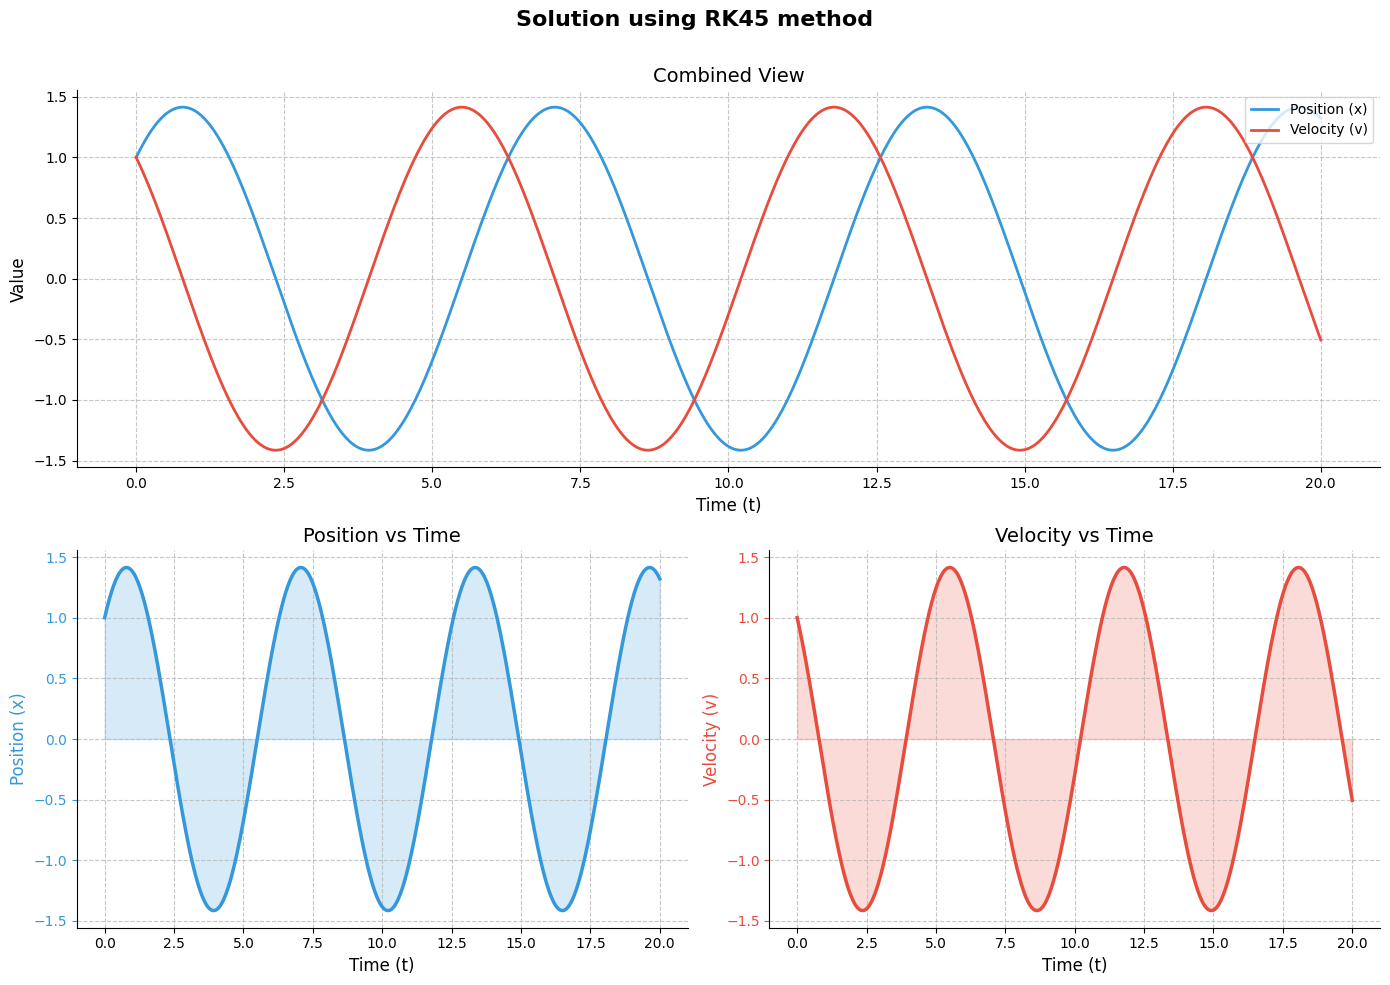

KeyboardInterrupt: 

In [20]:
y_= np.zeros(2) # Array to store the solution
y_[0] = 1. # Initial value of y
y_[1] = 1. # Initial value of y'
compare_plot(f,K, min_t, max_t-min_t, y_[0], y_[1], p, n, F_ext_func=F_ext, method_1='rk45', method_2='rk4')

In [ ]:
def compare_methods(f, y, t0, tf, method_1='rk4', method_2='rk45', tol=1e-8):
    # Initialize data storage
    results = {}
    fs = [f]
    for f in fs:
        # Run method 1
        t_values_1, y0_values_1, y1_values_1 = [t0], [y[0]], [y[1]]
        t_values_1, y0_values_1, y1_values_1, error_1, time_1 = ciclo_rk4(f, t0, y.copy(), t_values_1, y0_values_1, y1_values_1, tf)
        flops_1 = None  # RK4 doesn't directly provide FLOPs
            
        results[method_1] = {
            'time': time_1,
            'error': error_1,
            'flops': flops_1,
            't_values': t_values_1,
            'y0_values': y0_values_1,
            'y1_values': y1_values_1
            }
            
        # Run method 2
        t_values_2, y0_values_2, y1_values_2 = [t0], [y[0]], [y[1]]
        t_values_2, y0_values_2, y1_values_2, error_2, flops_2, time_2 = ciclo_rk45(f, t0, y.copy(), t_values_2, y0_values_2, y1_values_2, tf, Tol=tol)
            
        results[method_2] = {
        'time': time_2,
        'error': error_2,
        'flops': flops_2,
        't_values': t_values_2,
        'y0_values': y0_values_2,
        'y1_values': y1_values_2
        }
    

    # Create DataFrame for comparison
    df = pd.DataFrame({
    'Metric': ['Execution Time (s)', 'Total Error', 'FLOPS (if available)'],
    method_1: [results[method_1]['time'], results[method_1]['error'], results[method_1]['flops']],
    method_2: [results[method_2]['time'], results[method_2]['error'], results[method_2]['flops']]
    })
    
    print(df.to_string())  # Print the table

    # Plotting Error vs Time
    plt.figure(figsize=(12, 6))
    plt.plot(results[method_1]['t_values'], [results[method_1]['error']] * len(results[method_1]['t_values']), label=f'{method_1} Error', marker='o')
    plt.plot(results[method_2]['t_values'],  [results[method_2]['error']] * len(results[method_2]['t_values']), label=f'{method_2} Error', marker='x')
    plt.xlabel('Time (s)')
    plt.ylabel('Total Error')
    plt.title('Error vs Execution Time')
    plt.legend()
    plt.grid(True)
    plt.yscale('log')  # Use a logarithmic scale for better visualization of error
    plt.show()

# Example usage of the compare_methods function
compare_methods(f, y, min_t, max_t, tol=1e-2)

# Taller 2 - MFC
## Integrantes: 
- Giovanny Sierra Reina 
- Juan Carlos Quintero Rubiano

### Funcion a modelar: $$V(x)=\frac{1}{p}kx^{p} $$

In [ ]:
interact_plot()

- [x] Comprueba que la solución sigue siendo periódica con amplitud y periodo constantes para todas las condiciones iniciales, independientemente de las fuerzas que implementan efectos no lineales. Además, compruebe que la velocidad máxima se produce en $x= 0$ y la velocidad cero en el máximo valor de las $x-es$, siendo este último una consecuencia de la conservación de la energía.
- [x]  Compruebe que los osciladores no armónicos son ***no isócronos***, es decir, que vibraciones con amplitudes diferentes tienen periodos diferentes.
- [x] Explique por qué las formas de las oscilaciones cambian para diferentes valores de $p$.
- [x] Diseña un algoritmo para determinar el periodo T de la oscilación registrando los momentos en los que la masa pasa por el origen. Ten en cuenta que, como el movimiento puede ser asimétrico, debes registrar al menos tres veces para deducir el periodo.
- [x] Construye una gráfica del periodo deducido en función de la amplitud inicial.
- [x] Verifique que el movimiento es oscilatorio, pero no armónico, a medida que $p$ sepra el valor de $6$.

In [ ]:
def period(method = 'rk4'):
    t_values, y0_values, y1_values, _, _, _ = solve_EDO(f, y, min_t, max_t, method)

    # To find zero crossings, we need to look for sign changes
    T0_times = []  # Store times when y0 crosses zero
    T1_times = []  # Store times when y1 crosses zero

    # Find zero crossings for y0
    for i in range(1, len(y0_values)):
        # Check if there's a sign change (crossing zero)
        if y0_values[i-1] * y0_values[i] <= 0:
            # Linear interpolation to find approximate zero crossing time
            t0 = t_values[i-1]
            t1 = t_values[i]
            y0 = y0_values[i-1]
            y1 = y0_values[i]

            # If either point is exactly zero, use that time
            if y0 == 0:
                T0_times.append(t0)
            elif y1 == 0:
                T0_times.append(t1)
            else:
                # Linearly interpolate to find zero crossing time
                t_zero = t0 - y0 * (t1 - t0) / (y1 - y0)
                T0_times.append(t_zero)

    # Find zero crossings for y1
    for i in range(1, len(y1_values)):
        if y1_values[i-1] * y1_values[i] <= 0:
            t0 = t_values[i-1]
            t1 = t_values[i]
            y0 = y1_values[i-1]
            y1 = y1_values[i]

            if y0 == 0:
                T1_times.append(t0)
            elif y1 == 0:
                T1_times.append(t1)
            else:
                t_zero = t0 - y0 * (t1 - t0) / (y1 - y0)
                T1_times.append(t_zero)

    return t_values, T0_times, T1_times


In [ ]:
def plot_period():
    t_values, T0_times, T1_times = period('rk4')

    # Create arrays of zeros with the same length as the time arrays
    T0_values = [0] * len(T0_times)
    T1_values = [0] * len(T1_times)
    # Mark the zero crossings
    plt.plot(T0_times, T0_values, 'bo', label='T0 (y0=0)')
    plt.plot(T1_times, T1_values, 'ro', label='T1 (y1=0)')

    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Solution with Zero Crossings')
    plt.show()
plot_period()